# Uvod
lorem

In [988]:
import pandas as pd
from collections import Counter
import string
import datetime
import dateutil

In [989]:
data = pd.read_csv("data.csv", sep=";;;", engine="python")
data['Date'] =  pd.to_datetime(data['Date'], format='%Y-%m-%dT%H:%M:%S%z')

## Nestandardni znaki v oglasih
Ker so me pri zajemu podatkov zelo mučili nestandardni znaki ki jih ljudje postavljajo v svoje oglase si najprej oglejmo te.

### Ciljna vprašanja:
1. Kakšen procent znakov uporabljenih v imenih oglasov ni alfanumeričnih?
2. Kateri so najpogosteje uporabljeni ne-alfanumerični znaki?
3. Ali se v tem primeru splača narediti analizo brez uporabe knjižnice `pandas`?

Najprej se lotimo analize brez knjižnice `pandas`

In [990]:
def is_alphanum(char):
    # Funkcija šteje šumnike kot nealfanumerične znake vendar to dopuščamo saj v naši analizi štejemo šumnike pod nenavadne znake
    return (char in string.ascii_letters or char in string.digits)

In [991]:
c = Counter()
for ime in data.Name.to_list():
    for char in ime:
        # Ignorirajmo dolgočasne alfanumerične znake
        if not is_alphanum(char):
            c[char] += 1

Seveda pa izkoristimo `pandas` za prikaz rezultatov

In [992]:
def df_of_counter(cnt, *args, **kwargs):
    # takes collections.Counter of and returns pandas.DataFrame where first column is the keys and second column is the values
    
    column_1 = list(cnt.keys())
    column_2 = list(cnt.values())


    return pd.DataFrame(list(zip(column_1, column_2)), *args, **kwargs)

In [993]:
df = df_of_counter(c, columns=['CHARACTER', 'FREQUENCY']).sort_values('FREQUENCY', ascending=False).reset_index(drop=True)
df

,CHARACTER,FREQUENCY
0,,60200
1,",",4581
2,-,3738
3,/,3730
4,č,2018
5,.,1350
6,(,1087
7,),1055
8,+,905
9,š,657


Opravimo prejšnjo analizo še s pomočjo knjižnice `pandas`

In [994]:
s = data["Name"].apply(lambda x : pd.Series(list(x))).stack().reset_index(level=0, drop=True)
frequency_by_char = s.groupby(s).size().sort_values(ascending=False).to_frame().rename(columns={0: 'FREQUENCY'})

frequency_by_char.index.names = ['CHARACTER']
frequency_by_char.head(10)

,FREQUENCY
CHARACTER,
,60200
i,18996
a,17685
n,17245
o,15571
e,15206
r,12371
0,12296
l,8905


In [995]:
n_of_chars = frequency_by_char.sum().FREQUENCY
percentage = frequency_by_char / n_of_chars
percentage = percentage.rename(columns={"FREQUENCY" : "PERCENTAGE"})

characters_df = pd.concat([frequency_by_char, percentage], axis=1)
characters_df.head(10)

,FREQUENCY,PERCENTAGE
CHARACTER,,
,60200,0.147152
i,18996,0.046433
a,17685,0.043229
n,17245,0.042153
o,15571,0.038061
e,15206,0.037169
r,12371,0.030239
0,12296,0.030056
l,8905,0.021767


Opazimo, da je v tem primeru analiza ***izključno*** s knjižnico `pandas` vzela ***več*** procesorskega časa in bila ***manj berljiva*** kot naivna analiza s `pythonom`.

S tabelo `characters_df` se zdaj lotimo še preostalih dveh vprašanj tega poglavja

In [996]:
characters_df['ALFANUM'] = [is_alphanum(i) for i in characters_df.index.values]

alfanum = characters_df[characters_df.ALFANUM == True].drop(columns=["ALFANUM"])
not_alfanum = characters_df[characters_df.ALFANUM == False].drop(columns=["ALFANUM"])

In [997]:
print(f"V imenih oglasov se pojavi {int(alfanum.sum().FREQUENCY)} alfanumeričnih znakov, kar je {alfanum.sum().PERCENTAGE:.4f} deleža vseh znakov.")
print(f"V imenih oglasov se pojavi {int(not_alfanum.sum().FREQUENCY)} NE alfanumeričnih znakov, kar je {not_alfanum.sum().PERCENTAGE:.4f} deleža vseh znakov.")

V imenih oglasov se pojavi 327126 alfanumeričnih znakov, kar je 0.7996 deleža vseh znakov.
V imenih oglasov se pojavi 81976 NE alfanumeričnih znakov, kar je 0.2004 deleža vseh znakov.


Presenetljivo je petina uporabljenih znakov ne-alfanumeričnih. Oglejmo si podrobneje te znake

In [998]:
not_alfanum.head()

,FREQUENCY,PERCENTAGE
CHARACTER,,
,60200,0.147152
",",4581,0.011198
-,3738,0.009137
/,3730,0.009118
č,2018,0.004933


Vidimo, da na naš zaključek močno vpliva znak za presledek, ki, čeprav sicer ni alfanumerični, je popolnoma pričakovan v imenu oglasov. Kako bi statistika zgledala, če bi presledek šteli pod "običajne" oz. alfanumerične znake?

In [999]:
alfanum = pd.concat([not_alfanum[not_alfanum.index == " "], alfanum]) # Ker je presledek najpogostejši znak bo to ohranilo urejenost
not_alfanum = not_alfanum.drop(" ")

In [1000]:
print(f"Zdaj se v imenih oglasov pojavi {int(alfanum.sum().FREQUENCY)} alfanumeričnih znakov, kar je {alfanum.sum().PERCENTAGE:.4f} deleža vseh znakov.")
print(f"Zdaj se v imenih oglasov pojavi {int(not_alfanum.sum().FREQUENCY)} NE alfanumeričnih znakov, kar je {not_alfanum.sum().PERCENTAGE:.4f} deleža vseh znakov.")

Zdaj se v imenih oglasov pojavi 387326 alfanumeričnih znakov, kar je 0.9468 deleža vseh znakov.
Zdaj se v imenih oglasov pojavi 21776 NE alfanumeričnih znakov, kar je 0.0532 deleža vseh znakov.


In [1001]:
not_alfanum.head(50)

,FREQUENCY,PERCENTAGE
CHARACTER,,
",",4581,0.011198
-,3738,0.009137
/,3730,0.009118
č,2018,0.004933
.,1350,0.003300
(,1087,0.002657
),1055,0.002579
+,905,0.002212
š,657,0.001606


### Zaključek
1. Kakšen procent znakov uporabljenih v imenih oglasov ni alfanumeričnih?

    V imenih oglasov je **20.04%** vseh uporabljnih znakov ne-alfanumeričnih. Če se omejimo na nenavadne znake in v analizi ne upoštevamo presledka je ne-alfanumeričnih znakov **5.32%**.

2. Kateri so najpogosteje uporabljeni ne-alfanumerični znaki?

    Najpogosteje uporabljeni ne-alfanumerični znaki (delež uporabe večji kot 0.002) so `,`, `-`, `/`, `č`, `.`, `(`, `)` in `+`.
    
3. Ali se v tem primeru splača narediti analizo brez uporabe knjižnice `pandas`?

    Videli smo da je samo štetje znakov veliko bolj berljivo in hitrejše narediti brez uporabe `pandas`, vendar je nadaljna analiza, kljub temu, da bi bila možna brez knjižnice `pandas` veliko bolj elegantna z njeno uporabo.

## Mesta prodaje
Sedaj si oglejmo oglase glede na mesta iz katerih so bili oddani in naredimo način da iz stolpca `CITY` v katerem so trenutno podatki oblike `mesto, ulica` izluščimo samo mesto.

### Ciljna vprašanja:
1. Iz katerih mest je oddanih največ oglasov?
2. Iz katerih mest je oddanih najmanj oglasov?
3. Iz katerega dela Ljubljane je oddanih največ oglasov?
4. Ali se v tem primeru splača narediti analizo s knjižnico `pandas`?

Zopet se najprej lotimo 4. točke

In [1002]:
def city_of_location_1(location):
    # V nadaljevanju bomo videli zakaj smo funkcijo poimenovali z _1

    if len(l := location.split(", ")) == 2:
        city, _ = l
    else:
        city = l[0]
    
    return city

In [1003]:
d = Counter()
for location in data.City.to_list():
    city = city_of_location_1(location)
    d[city] += 1

In [1004]:
df = df_of_counter(d, columns=["CITY", "N_OF_ADDS"]).sort_values('N_OF_ADDS', ascending=False).reset_index(drop=True)
df.head(10)

,CITY,N_OF_ADDS
0,Maribor,1303
1,Ljubljana Moste Polje,953
2,Ljubljana Bežigrad,505
3,Ljubljana Šiška,456
4,Nova Gorica,419
5,Ljubljana Center,367
6,Ljubljana Vič Rudnik,343
7,Domžale,273
8,Kranj,270
9,Celje,251


Vidimo da bi morali biti
- Ljubljana Moste Polje
- Ljubljana Bežigrad
- Ljubljana Šiška
- Ljubljana Center
- Ljubljana Vič Rudnik
- Ljubljana

združeni, zato malce modificirajmo našo funkcijo

In [1005]:
def city_of_location(location):
    LJUBLJANE = ["Ljubljana Moste Polje", "Ljubljana Bežigrad", "Ljubljana Šiška", "Ljubljana Center", "Ljubljana Vič Rudnik"]
    if len(l := location.split(", ")) == 2:
        city, _ = l

        # Če smo v enem izmed sekcij Ljubljane
        if city in LJUBLJANE:
            city = "Ljubljana"
    else:
        city = l[0]
    
    return city

In [1006]:
d = Counter()
for location in data.City.to_list():
    city = city_of_location(location)
    d[city] += 1

In [1007]:
df = df_of_counter(d, columns=["CITY", "N_OF_ADDS"]).sort_values('N_OF_ADDS', ascending=False).reset_index(drop=True)
df.head(10)

,CITY,N_OF_ADDS
0,Ljubljana,2836
1,Maribor,1303
2,Nova Gorica,419
3,Domžale,273
4,Kranj,270
5,Celje,251
6,Slovenska Bistrica,229
7,Koper,185
8,Škofljica,183
9,Slovenske Konjice,166


Kako težko pa bi se bilo tega problema lotiti s knjižnico `pandas`?

In [1008]:
data["Filtered_city"] = data["City"].map(city_of_location) # Ker v nadaljevanju želimo natančneje pogledati ljubljane ustvarimo nov stolpec za mesta

mesta = data.groupby("Filtered_city").size().to_frame(name="N_OF_ADDS").sort_values('N_OF_ADDS', ascending=False)
mesta.index.names = ['City']
mesta.head(10)

,N_OF_ADDS
City,
Ljubljana,2836
Maribor,1303
Nova Gorica,419
Domžale,273
Kranj,270
Celje,251
Slovenska Bistrica,229
Koper,185
Škofljica,183


In [1009]:
mesta['PERCENTAGE'] = mesta / len(data)
mesta.head(10)

,N_OF_ADDS,PERCENTAGE
City,,
Ljubljana,2836,0.284311
Maribor,1303,0.130627
Nova Gorica,419,0.042005
Domžale,273,0.027368
Kranj,270,0.027068
Celje,251,0.025163
Slovenska Bistrica,229,0.022957
Koper,185,0.018546
Škofljica,183,0.018346


Zaključimo, da je v tem primeru koda lepša in hitrejša s knjižnico `pandas`.

Oglejmo si zdaj mesta z največ

<AxesSubplot:xlabel='City'>

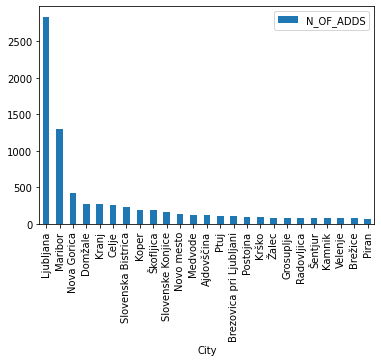

In [1010]:
mesta.reset_index().head(25).plot.bar(x='City', y='N_OF_ADDS')

in najmanj oglasov.

In [1011]:
mesta[mesta.N_OF_ADDS == 1]

,N_OF_ADDS,PERCENTAGE
City,,
Bistrica ob Sotli,1,0.0001
Gorenja vas - Poljane,1,0.0001
Hajdina,1,0.0001
Hodoš,1,0.0001
Bovec,1,0.0001
Kobilje,1,0.0001
Kontinentalna Hrvaška,1,0.0001
Rogašovci,1,0.0001
Poljska,1,0.0001


Kako pa zgleda število oglasov iz določenih regij ljubljane?

In [1012]:
def f(x):
    return pd.Series(x.split(", "))

ljubljane = data[data.Filtered_city == "Ljubljana"][["City"]]
ljubljane = ljubljane.City.apply(f).rename(columns={0 : "Ljubljana", 1 : "Sekcija"}).sort_values(['Ljubljana', 'Sekcija']).reset_index(drop=True)
ljubljane

,Ljubljana,Sekcija
0,Ljubljana,Brezje pri Lipoglavu
1,Ljubljana,Carinska pošta
2,Ljubljana,Dolenjska
3,Ljubljana,Dolenjska
4,Ljubljana,Dolenjska
...,...,...
2831,Ljubljana Šiška,Šiška
2832,Ljubljana Šiška,Šiška
2833,Ljubljana Šiška,Šiška
2834,Ljubljana Šiška,Šiška


In [1013]:
by_ljubljana = ljubljane.groupby("Ljubljana").size().sort_values(ascending=False).to_frame().rename(columns={0: "N_OF_ADDS"})
by_ljubljana['PERCENTAGE_OF_ALL'] = by_ljubljana / len(data)

by_ljubljana

,N_OF_ADDS,PERCENTAGE_OF_ALL
Ljubljana,,
Ljubljana Moste Polje,953,0.095539
Ljubljana Bežigrad,505,0.050627
Ljubljana Šiška,456,0.045714
Ljubljana Center,367,0.036792
Ljubljana Vič Rudnik,343,0.034386
Ljubljana,212,0.021253


<AxesSubplot:xlabel='Ljubljana'>

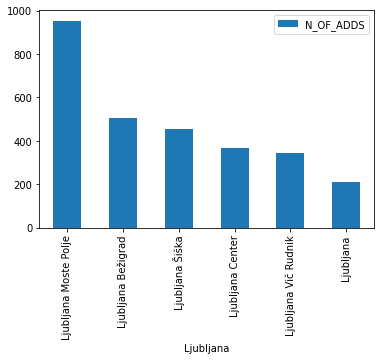

In [1014]:
by_ljubljana.plot.bar(y='N_OF_ADDS')

Največ oglasov je torej oddanih iz **Ljubljana Moste Polje**. Poglejmo si še natančneje to regijo.

In [1015]:
moste_polje = ljubljane[ljubljane.Ljubljana == "Ljubljana Moste Polje"].reset_index(drop=True)
moste_polje = moste_polje.groupby("Sekcija").size().sort_values(ascending=False).to_frame().rename(columns={0: "N_OF_ADDS"})
moste_polje['PERCENTAGE_OF_ALL'] = moste_polje / len(data)
moste_polje.head(10)

,N_OF_ADDS,PERCENTAGE_OF_ALL
Sekcija,,
BTC,371,0.037193
Jarše,139,0.013935
Moste,88,0.008822
Nove Fužine,77,0.007719
Nove Jarše,76,0.007619
Polje,48,0.004812
Dobrunje,45,0.004511
Štepanjsko naselje,26,0.002607
Zalog,18,0.001805


<AxesSubplot:xlabel='Sekcija'>

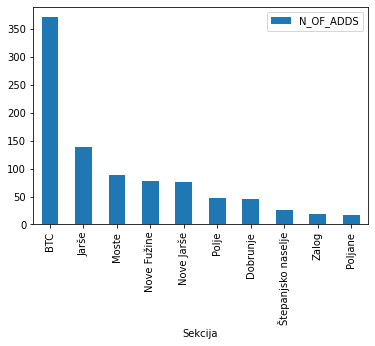

In [1016]:
moste_polje.head(10).plot.bar(y="N_OF_ADDS")

Preden zaključimo poglavje še popravimo tabelo `data`. V nadaljnji analizi nas namreč mesto ne bo zanimalo v tolikšne detajle kot nas je v tem poglavju.

In [1017]:
data = data.drop(columns=["City"]).rename(columns={"Filtered_city" : "City"})
data.head()

,Name,Date,Price,City
0,MINING RIG - Rudarjenje - Ethereum - 1.1GH/s -...,2021-10-16 12:40:29+02:00,28999,Ljubljana
1,Mining rig 18x rx5700xt,2021-11-02 20:28:51+01:00,18500,Ormož
2,Bitman Antminer S19 Pro 110 Th,2021-10-18 21:29:02+02:00,16300,Ljubljana
3,Mining rig RTX 3070 9 kom 570MH/s,2021-11-06 15:28:47+01:00,14000,Kungota
4,NOV mining Rig z 6 x Nvidia RTX3080Ti - 510 Mhs,2021-10-18 09:09:12+02:00,13590,Maribor
...,...,...,...,...
9970,Router Zyxel P-2812HNU-F1 vT,2021-10-29 13:07:25+02:00,23,Ljubljana
9971,Mac iLife 09 DVD,2021-10-28 13:58:02+02:00,23,Ljubljana
9972,Originalni HP polnilec napajalnik za prenosnik...,2021-10-23 17:20:37+02:00,23,Ljubljana
9973,Originalni HP polnilec napajalnik za prenosnik...,2021-10-23 17:20:34+02:00,23,Ljubljana


### Zaključek
1. Iz katerih mest je oddanih največ oglasov?

    Drastično največ oglasov je oddanih iz ***Ljubljane*** in ***Maribora***. Relativno veliko oglasov je oddanih tudi iz ***Nove Gorice***.

2. Iz katerih mest je oddanih najmanj oglasov?

    Samo en oglas je oddan iz 21 mest. Med njimi v oči bodeta ***Kontinentalna Hrvaška*** in ***Poljska***.

3. Iz katerega dela Ljubljane je oddanih največ oglasov?

    Največ oglasov je oddanih iz ***Ljubljana Moste Polje***, natančneje iz ***BTC***-ja.

4. Ali se v tem primeru splača narediti analizo s knjižnico `pandas`?

    Za kompleksno analizo ki smo jo delali v tem poglavju je bila knjižnica `pandas` nepogrešljiva in je propomogla k lepši in hitrejši kodi.

## Cena
V naslednjem poglavju si oglejmo nekaj statistik povezanih s ceno.

Opomnimo, da so tukaj podatki nekoliko pristranski, saj smo iz bolhe potegnili 1000 najdražjih oglasov.

### Ciljna vprašanja:
1. Kolikšna je cena pri najcenejšem in najdražjem oglasu?
2. Kolikšna je povprečna cena?
3.

In [1018]:
print(f"Najdražji oglas stane {data['Price'].max()} EUR")
print(f"Najcenejši pa {data['Price'].min()} EUR")
print(f"Povprečna cena oglasa pa je {data['Price'].mean()} EUR s standardno deviacijo {data['Price'].std(ddof=0)}")

Najdražji oglas stane 28999 EUR
Najcenejši pa 23 EUR
Povprečna cena oglasa pa je 316.24671679197996 EUR s standardno deviacijo 811.7818745899536


Katera mesta pa imajo v povprečju najdražje oglase?

<AxesSubplot:xlabel='City'>

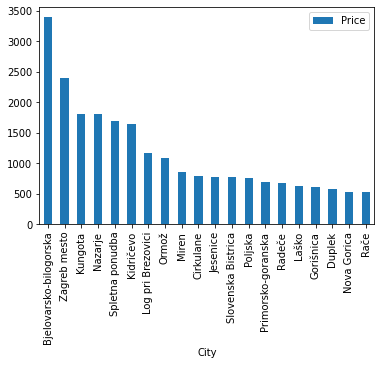

In [1019]:
df = data.groupby("City").mean().sort_values('Price', ascending=False).head(20)
df.reset_index().head(25).plot.bar(x='City', y='Price')

Oglejmo si kateri oglasi so to

In [1020]:
most_expensive = list(data.groupby("City").mean().sort_values('Price', ascending=False).head(8).index.values)
data.loc[data['City'].isin(most_expensive)].sort_values(["City", "Price"], ascending=[True, False]).set_index(["City", "Name"]).head(60)

Date  \
City                   Name                                                                            
Bjelovarsko-bilogorska Ricoh pro c 751                                     2021-10-07 10:43:26+02:00   
                       Ricoh mpc 6502                                      2021-10-07 10:43:31+02:00   
Kidričevo              MINING RIG  6XNvidia 3070 Odklenjene niso LHR       2021-11-04 13:01:25+01:00   
                       Nov Mining Rig 5xAmd rx 580 8G                      2021-11-03 12:37:16+01:00   
                       prodam                                              2021-10-28 10:02:10+02:00   
                       HP elitebook 8460p                                  2021-11-07 11:11:31+01:00   
                       Lenovo ThinkPad Yoga 11e                            2021-11-05 16:33:01+01:00   
                       Tablični Medion                                     2021-11-07 11:20:09+01:00   
                       2x8GB SO-DIMM DDR4 ram za prenosnik                 2021-11-02 15:07:29+01:00   
                       Tablični računalnik Atheros z ovitkom               2021-10-09 17:17:20+02:00   
                       Računalniška miza                                   2021-10-22 18:11:19+02:00   
Kungota                Mining rig RTX 3070 9 kom 570MH/s                   2021-11-06 15:28:47+01:00   
                       MacBook Pro 15, Retina, i7, 16 GB, 1TB+256GB, 2...  2021-11-06 15:28:25+01:00   
                       prodam gaming racunalnik                            2021-10-21 12:15:01+02:00   
                       Prenosni računalnik Acer                            2021-11-04 12:21:30+01:00   
                       ASUS Maximus VIII Impact + i7 6700K + Corsair 1...  2021-10-31 22:48:12+01:00   
                       Računalniški Procesor Intel i5 6600K (LGA 1151)     2021-11-04 15:09:31+01:00   
                       Fotografski optični bralnik HP Scanjet G3010 -b...  2021-10-21 20:57:49+02:00   
                       Procesor Intel i5 4690K (LGA 1150)                  2021-10-26 16:15:03+02:00   
                       Apple DVD drive                                     2021-11-06 15:28:30+01:00   
Log pri Brezovici      Prodam tiskalnik BN 20 ,prakticno nov               2021-10-26 15:23:57+02:00   
                       DELL XPS 15 (9560)                                  2021-10-19 20:23:15+02:00   
                       Samsung Galaxy Tab S6 Lite                          2021-10-11 11:17:35+02:00   
                       Canon iRC 2880                                      2021-10-23 19:06:06+02:00   
                       Toner Kyocera TK-590 komplet                        2021-10-21 15:42:57+02:00   
                       Računalnik HP Compaq Intel Core                     2021-10-20 19:27:39+02:00   
Nazarje                gaming računalnik                                   2021-10-09 15:15:04+02:00   
Ormož                  Mining rig 18x rx5700xt                             2021-11-02 20:28:51+01:00   
                       iMAC namizni računalnik                             2021-11-02 10:48:54+01:00   
                       PNY Quadro P2200 grafična kartica, 5GB GDDR5X (...  2021-10-24 01:35:35+02:00   
                       21 x Vintage ročne igrice igralne konzole, ročn...  2021-11-02 20:55:37+01:00   
                       Prenosnik ACER Aspire 5750G + LCD TV-Monitor Sa...  2021-11-04 17:23:50+01:00   
                       PRODAM PLAYSTATION 4                                2021-10-25 08:57:11+02:00   
                       NINTENDO GAMECUBE + 4 igre,game cube,Fifa 06,to...  2021-11-02 20:55:36+01:00   
                       SYNOLOGY DS411slim                                  2021-10-12 21:58:04+02:00   
                       ATARI 2600 VIDEO GAME, igralna konzola              2021-11-03 18:00:13+01:00   
                       4 X WORLD OF WARCRAFT IGRA                          2021-10-18 22:03:35+02:00   
                       2600 VIDEO COMPUT

Kakšna pa je korelacija med ceno in časom objave?

<AxesSubplot:xlabel='Date', ylabel='Price'>

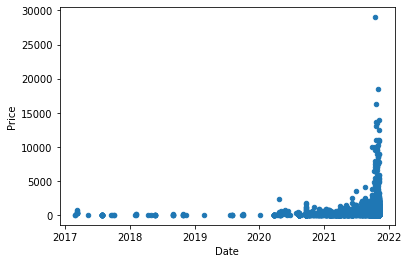

In [1021]:
data.plot.scatter('Date', 'Price')


Presenetljivo so najdražji artikli tudi najnovejši. Kateri pa so najstarejši oglasi?
## Stari oglasi

In [1022]:
END_DATE = datetime.datetime(2020, 1, 1, 0, 0, 0, tzinfo=dateutil.tz.tz.tzoffset(None, 0)) #2020-01-02T00:00:00+00:00
df = data[data.Date < END_DATE].reset_index(drop=True)
df.head(20)

,Name,Date,Price,City
0,"Omara za strežnik, server - kabinet 600x1200 4...",2017-03-08 20:14:10+01:00,728,Ljubljana
1,"Omara za strežnik, server - kabinet 800x800 42...",2017-03-08 20:15:23+01:00,559,Ljubljana
2,"Omara za strežnik, server - kabinet 600x800 18...",2017-03-08 20:12:54+01:00,367,Ljubljana
3,"Omara za strežnik, server - kabinet 600x800 12...",2017-03-08 20:09:38+01:00,358,Ljubljana
4,"Omara za strežnik, server - kabinet 600x900 15...",2017-03-08 20:11:47+01:00,356,Ljubljana
5,"Omara za strežnik, server - kabinet 600x800 22...",2017-03-08 20:18:01+01:00,341,Ljubljana
6,"Omara za strežnik, server - kabinet 600x600 22...",2017-03-08 20:16:50+01:00,331,Ljubljana
7,"Omara za strežnik, server - kabinet 600x600 22...",2017-03-08 20:06:29+01:00,331,Ljubljana
8,"Omara za strežnik, server - kabinet 600x600 15...",2017-03-08 20:05:10+01:00,309,Ljubljana
9,Rezervno napajanje 600W 12/220V,2018-10-27 09:00:37+02:00,157,Ljubljana


Iz katerih mest so in kakšne so njihove cene?

In [1023]:
df["City"] = df["City"].map(to_city)
df.groupby("City").size()

City
Ajdovščina           1
Kranj                1
Ljubljana           57
Maribor              3
Selnica ob Dravi     2
dtype: int64

In [1024]:
print(f"Povprečna cena oglasov starejših od leta 2020 je {df['Price'].mean()}")

Povprečna cena oglasov starejših od leta 2020 je 93.734375


## Tipi artiklov
Da bomo boljše razumeli kakšni tipi artiklov se prodajajo na bolhi poskušajmo narediti funkcijo ki nam bo iz imena dala tip artikla. To naredimo tako da najprej z vnaprej ustvarjeno bazo podatko klasificiramo artikle za katere smo prepičani kam sodijo, nato pa uporabimo naivni bayesov klasifikator.

In [1025]:

def guaranteed_type(name):
    def koren_besede(beseda):
        beseda = ''.join(znak for znak in beseda if znak.isalpha())
        if not beseda:
            return '$'
        konec = len(beseda) - 1
        if beseda[konec] in 'ds':
            konec -= 1
        while konec >= 0 and beseda[konec] in 'aeiou':
            konec -= 1
        return beseda[:konec + 1]

    guaranteed_types = {
        "Mining Rig" : {"mining", "rig", "rudarjenje", "miner",},
        "PC" : {"pc", "macbook", "prenosnik", "računalnik", "racunalnik"},
        "Tiskalnik" : {"tiskalnik", "printer"},
        "Kartuše" : {"kartuše", "kartuse"},
        "Monitor" : {"monitor", "zaslon"},
        "Domena" : {"domena"},
        "Tipkovnica" : {"tipkovnica", "keyboard"},
        "Miška" : {"miska", "miška", "mouse"},
        "Slušalke" : {"slusalke", "slušalke", "headphones", "headset"},
        "Baterija" : {"baterija", "battery"},
        "Igralna konzola" : {"playstation", "xbox", "ps4", "gameboy", "switch", "konzola"},
        "Matična plošča" : {"matična", "maticna", "plosca", "plošča", "motherboard"},
        "Trdi disk" : {"trdi", "disk", "hard", "drive"},
        "Pomnilnik" : {"memory", "ram", "pomnilnik"},
        "Napajalnik" : {"napajalnik", "charger", "psu"},
        "Server" : {"strežnik", "streznik", "server"},
        "GPU" : {"grafična", "graficna", "kartica", "gpu", "graphics", "card"},
        "CPU" : {"procesor", "cpu", "processor"},
        "Kamera" : {"camera", "kamera"},
        "Zvočniki" : {"zvocniki", "zvočniki", "speakers"},
        "Router" : {"router"},
        "Kalkulator" : {"kalkulator", "calculator"}
    }

    words_in_name = set(map(koren_besede, name.lower().split()))
    
    intersection = {key : len(set(map(koren_besede, guaranteed_types[key])) & words_in_name) for key in guaranteed_types}
    if (most_words := sorted(intersection.items(), key=lambda item: item[1], reverse=True)[0])[1]:
        return most_words[0]
    else:
        return "Couldn't determine type"

os.remove("test/predictions.csv")
data['Prediction'] = data.Name.apply(guaranteed_type)
data[["Name", "Prediction"]].set_index("Name").sort_values("Prediction").to_csv("test/predictions.csv")


Vidimo da nam je uspelo klasificirati nekoliko več kot 60% podatkov

In [1026]:
raw = data.groupby("Prediction").size().sort_values(ascending=False)
percentage = data.groupby("Prediction").size().sort_values(ascending=False) / len(data)
pd.concat([raw, percentage], axis=1).rename(columns={0 : 'Amount', 1 : 'Percentage'})

,Amount,Percentage
Prediction,,
Couldn't determine type,3790,0.379950
PC,2449,0.245514
Igralna konzola,994,0.099649
Monitor,357,0.035789
Pomnilnik,339,0.033985
Tiskalnik,299,0.029975
Trdi disk,281,0.028170
Tipkovnica,202,0.020251
GPU,194,0.019449


Poskusimo zdaj klasificirati preostale podatke z naivnim Bayesovim klasifikatorjem kot smo se učili na predavanjih. Najprej potrebujemo verjetnost napovedi glede na vse uspešne napovedi (predpostavimo da je verjetnost v neklasificiranih podatkih enaka verjetnosti v klasificiranih)

In [1027]:
type_probability = data[data.Prediction != "Couldn't determine type"].groupby('Prediction').size() / len(data[data.Prediction != "Couldn't determine type"])
type_probability.sort_values(ascending=False)


Prediction
PC                 0.395958
Igralna konzola    0.160711
Monitor            0.057720
Pomnilnik          0.054810
Tiskalnik          0.048343
Trdi disk          0.045432
Tipkovnica         0.032660
GPU                0.031366
Matična plošča     0.024414
Napajalnik         0.022797
CPU                0.021827
Miška              0.017300
Router             0.014551
Mining Rig         0.014228
Kartuše            0.011641
Slušalke           0.011156
Baterija           0.010994
Server             0.008246
Kamera             0.007599
Zvočniki           0.004689
Domena             0.001940
Kalkulator         0.001617
dtype: float64

Nato naredimo razpredelnico napovedi in besed ki se pojavijo v napovedi

In [1028]:
def f(x):
    return pd.Series(x.split())

words_in_predictions = data[data.Prediction != "Couldn't determine type"].set_index('Prediction').Name.apply(f).stack().reset_index(level='Prediction').rename(columns={0: 'Word'})
words_in_predictions.head()

,Prediction,Word
0,Mining Rig,MINING
1,Mining Rig,RIG
2,Mining Rig,-
3,Mining Rig,Rudarjenje
4,Mining Rig,-


S funkcijo crosstab preštejemo kombinacije. Iz prvega dela analize se bomo spomnili da imamo veliko "besed" ki so pravzaprav ascii znaki

In [1029]:
word_by_prediction = pd.crosstab(words_in_predictions.Word, words_in_predictions.Prediction)
word_by_prediction.head()

Prediction,Baterija,CPU,Domena,GPU,Igralna konzola,Kalkulator,Kamera,Kartuše,Matična plošča,Mining Rig,...,Napajalnik,PC,Pomnilnik,Router,Server,Slušalke,Tipkovnica,Tiskalnik,Trdi disk,Zvočniki
Word,,,,,,,,,,,,,,,,,,,,,
!,0,0,0,0,0,0,0,0,0,0,...,0,3,0,0,0,0,0,0,0,0
!!,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
!!!,0,0,0,0,0,0,0,0,0,0,...,1,2,0,0,0,0,0,0,0,0
!!!TOP,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
!),1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Verjetnosti dobimo tako da stolpce delimo z verjetnostjo posameznega žanra. Oglejmo si najpogostejše "besede" ki se uporabljajo v oglasih za procesorje

In [1030]:
probability_by_prediction = word_by_prediction / data[data.Prediction != "Couldn't determine type"].groupby('Prediction').size() + 0.001
probability_by_prediction.CPU.sort_values(ascending=False).head()

Word
PROCESOR    0.267667
Intel       0.252852
procesor    0.223222
Procesor    0.215815
INTEL       0.208407
Name: CPU, dtype: float64

Definirajmo funkcijo in jo preizkusimo na nekaterih, prej neklasificiranih, oglasih

In [1031]:
def determine_type(opis):
    factors = type_probability * probability_by_prediction[probability_by_prediction.index.isin(f(opis))].prod()
    factors /= max(factors)
    return factors.sort_values(ascending=False)

In [1032]:
determine_type("NVIDIA GeForce GTX 1060 6GB ( Inno3D)").head()

Prediction
GPU                1.000000e+00
Mining Rig         1.085979e-01
PC                 1.041277e-03
Pomnilnik          7.417969e-04
Igralna konzola    3.413971e-07
dtype: float64

Seveda klasifikacija ni 100% natančna

In [1033]:
determine_type("FORTNITE + GTA 5 ONLINE - RADEON HD7950").head()

Prediction
Igralna konzola    1.000000
PC                 0.409953
GPU                0.122173
Mining Rig         0.110331
Pomnilnik          0.009591
dtype: float64

In ne deluje na artiklih ki jih z našim naivnim zagotovim klasificiranjem nismo pobrali

In [1034]:
determine_type("Gaming stol LC-Power črno/rdeč").head()

Prediction
PC            1.000000
Monitor       0.136569
Miška         0.134345
Slušalke      0.134007
Tipkovnica    0.099618
dtype: float64